# Modelos para a classificação de diabetes


É importante ressaltar que os dados do Vigitel não devem ser analisados no Excel, do pacote Office (ou programa semelhante), pois a amostra do Vigitel leva em consideração fatores de ponderação para a análise de dados.

É necessário o uso de programas como o Epi Info ou R, ou, ainda, Stata, SPSS, SAS, entre outros, que possuem módulos de análise específicos para a utilização de fatores de ponderação

Link da base: https://svs.aids.gov.br/download/Vigitel/

trabalho relacionado que usou vigitel: https://www.scielo.br/j/ress/a/6hn69ts9c5mkPjHcGBMBbGJ/?lang=pt

referências:
artigo que usa métodos de ml para prever diabetico ou não
https://www.mdpi.com/1424-8220/22/16/6155

# Tratamento de dados

#### Bibliotecas e setar diretório

rodar e reiniciar..

In [38]:
try:
  import dython
  from dython.nominal import associations
except:
  ! pip install dython
  import dython
  from dython.nominal import associations

In [39]:

# import pkg_resources
# # pkg_resources.require("numpy== 1.22.4")
# import numpy as np
# !pip show numpy

# import dython
# from dython.nominal import associations

In [40]:
import pandas as pd 
pd.set_option('display.max_columns', 250)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

In [41]:

from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import de dados

In [43]:
# read file from google drive at folder databetes
# file_path = 'drive/My Drive/databetes/Vigitel-2021-peso-rake.xls'
# file_path = 'drive/My Drive/databetes/Vigitel-2020-peso-rake.xls'
file_path = 'drive/My Drive/databetes/data/processed/df_tratado.csv'
# file_path = '../data/Vigitel-2019-peso-rake.xls'
# df = pd.read_excel(file_path, sheet_name='Sheet1')
df = pd.read_csv(file_path)

In [44]:
df

,chave,replica,ano,cidade,região,sexo,idade (anos),faixa etária (anos),grau escolaridade,pressão alta,bebida alcoólica,freq alcool,exercício físico,cor,peso (kg),altura (cm),imc,classe imc,freq horta,freq refrigerante,moradores,fumante,posse plano saúde,idade início diabetes,diabetes
0,1,1,2015,Aracajú,Nordeste,masculino,59,55 a 64,1º grau ou fundamental ou supletivo de 1º grau,não,não,NaN,não,branca,76.0,172.0,25.7,sobrepeso,todos os dias (inclusive sábado e domingo),nunca,3,não,não,NaN,não
1,2,1,2015,Aracajú,Nordeste,feminino,20,18 a 24,2º grau ou colégio ou técnico ou normal ou cie...,sim,não,NaN,não,parda,84.0,162.0,32.0,obesidade classe I,5 a 6 dias por semana,1 a 2 dias por semana,7,não,não,NaN,não
2,4,1,2015,Aracajú,Nordeste,feminino,32,25 a 34,"pós-graduação (especialização, mestrado, douto...",não,não,NaN,sim,preta,45.0,160.0,17.6,baixo peso,3 a 4 dias por semana,quase nunca,2,não,"sim, apenas um",NaN,não
3,5,1,2015,Aracajú,Nordeste,feminino,70,65+,2º grau ou colégio ou técnico ou normal ou cie...,sim,sim,1 a 2 dias por semana,sim,parda,62.0,153.0,26.5,sobrepeso,todos os dias (inclusive sábado e domingo),nunca,2,não,"sim, apenas um",NaN,não
4,7,1,2015,Curitiba,Sul,feminino,84,65+,curso primário,sim,não,NaN,não,branca,51.0,140.0,26.0,sobrepeso,todos os dias (inclusive sábado e domingo),nunca,1,não,"sim, apenas um",84.0,sim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235425,72213241096,33,2021,São Paulo,Sudeste,feminino,72,65+,3º grau ou curso superior,não,não,NaN,não,parda,44.0,153.0,18.8,adequado ou eutrófico,quase nunca,nunca,2,não,não,NaN,não
235426,45314403046,26,2021,Belo Horizonte,Sudeste,feminino,67,65+,"pós-graduação (especialização, mestrado, douto...",sim,sim,1 a 2 dias por semana,não,parda,64.0,156.0,26.3,sobrepeso,todos os dias (inclusive sábado e domingo),quase nunca,6,não,"sim, mais de um",NaN,não
235427,26374242025,4,2021,Vitória,Sudeste,feminino,75,65+,3º grau ou curso superior,não,sim,menos de 1 dia por semana,não,parda,60.0,147.0,27.8,sobrepeso,todos os dias (inclusive sábado e domingo),quase nunca,4,não,"sim, apenas um",NaN,não
235428,22312495026,36,2021,Porto Alegre,Sul,feminino,77,65+,"pós-graduação (especialização, mestrado, douto...",sim,não,NaN,não,preta,58.0,162.0,22.1,adequado ou eutrófico,todos os dias (inclusive sábado e domingo),nunca,1,não,não,NaN,não


Contagem de dados nulos

In [45]:
nas_count = df.isna().sum()[df.isna().sum()>0]
nas_count = nas_count.sort_values()

In [46]:
nas_count

freq alcool              143036
idade início diabetes    215929
dtype: int64

In [47]:
diabetes_count = df['diabetes'].value_counts()
diabetes_count

não    212432
sim     22998
Name: diabetes, dtype: int64

## Subset para as variáveis selecionadas

faixa etária
escolaridade
IMC
pressão alta
frequência de consumo de álcool
cor
atividade física

In [48]:
rename_cols_dict = {
                          'q6':'idade (anos)',
                          'classe imc': 'classe_imc',
                          'grau escolaridade':'grau_escolaridade',
                          'bebida alcoólica':'bebida_alcoolica',
                          'freq alcool':'freq_alcool',
                          'exercício físico':'exercicio_fisico',
                          'q45':'freq_exercicio',
                          'pressão alta':'pressao_alta',
                          'faixa etária (anos)':'faixa_etaria'
                               }

In [49]:
df = df.rename(columns=rename_cols_dict)

In [52]:
df

,chave,replica,ano,cidade,região,sexo,idade (anos),faixa_etaria,grau_escolaridade,pressao_alta,bebida_alcoolica,freq_alcool,exercicio_fisico,cor,peso (kg),altura (cm),imc,classe_imc,freq horta,freq refrigerante,moradores,fumante,posse plano saúde,idade início diabetes,diabetes
0,1,1,2015,Aracajú,Nordeste,masculino,59,55 a 64,1º grau ou fundamental ou supletivo de 1º grau,não,não,NaN,não,branca,76.0,172.0,25.7,sobrepeso,todos os dias (inclusive sábado e domingo),nunca,3,não,não,NaN,não
1,2,1,2015,Aracajú,Nordeste,feminino,20,18 a 24,2º grau ou colégio ou técnico ou normal ou cie...,sim,não,NaN,não,parda,84.0,162.0,32.0,obesidade classe I,5 a 6 dias por semana,1 a 2 dias por semana,7,não,não,NaN,não
2,4,1,2015,Aracajú,Nordeste,feminino,32,25 a 34,"pós-graduação (especialização, mestrado, douto...",não,não,NaN,sim,preta,45.0,160.0,17.6,baixo peso,3 a 4 dias por semana,quase nunca,2,não,"sim, apenas um",NaN,não
3,5,1,2015,Aracajú,Nordeste,feminino,70,65+,2º grau ou colégio ou técnico ou normal ou cie...,sim,sim,1 a 2 dias por semana,sim,parda,62.0,153.0,26.5,sobrepeso,todos os dias (inclusive sábado e domingo),nunca,2,não,"sim, apenas um",NaN,não
4,7,1,2015,Curitiba,Sul,feminino,84,65+,curso primário,sim,não,NaN,não,branca,51.0,140.0,26.0,sobrepeso,todos os dias (inclusive sábado e domingo),nunca,1,não,"sim, apenas um",84.0,sim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235425,72213241096,33,2021,São Paulo,Sudeste,feminino,72,65+,3º grau ou curso superior,não,não,NaN,não,parda,44.0,153.0,18.8,adequado ou eutrófico,quase nunca,nunca,2,não,não,NaN,não
235426,45314403046,26,2021,Belo Horizonte,Sudeste,feminino,67,65+,"pós-graduação (especialização, mestrado, douto...",sim,sim,1 a 2 dias por semana,não,parda,64.0,156.0,26.3,sobrepeso,todos os dias (inclusive sábado e domingo),quase nunca,6,não,"sim, mais de um",NaN,não
235427,26374242025,4,2021,Vitória,Sudeste,feminino,75,65+,3º grau ou curso superior,não,sim,menos de 1 dia por semana,não,parda,60.0,147.0,27.8,sobrepeso,todos os dias (inclusive sábado e domingo),quase nunca,4,não,"sim, apenas um",NaN,não
235428,22312495026,36,2021,Porto Alegre,Sul,feminino,77,65+,"pós-graduação (especialização, mestrado, douto...",sim,não,NaN,não,preta,58.0,162.0,22.1,adequado ou eutrófico,todos os dias (inclusive sábado e domingo),nunca,1,não,não,NaN,não


In [50]:
# df_ada = df_ada.rename(columns={"hart": "hipertensao", "q42": "ativo_fis","diab":"diabetes","q9_i":"peso","q11":"altura","q7":"sexo","fet":"faixa_etaria"})

In [53]:
df_model = df[['imc','pressao_alta','grau_escolaridade','bebida_alcoolica','exercicio_fisico','freq_alcool','faixa_etaria','diabetes']]


In [54]:
df_model

,imc,pressao_alta,grau_escolaridade,bebida_alcoolica,exercicio_fisico,freq_alcool,faixa_etaria,diabetes
0,25.7,não,1º grau ou fundamental ou supletivo de 1º grau,não,não,NaN,55 a 64,não
1,32.0,sim,2º grau ou colégio ou técnico ou normal ou cie...,não,não,NaN,18 a 24,não
2,17.6,não,"pós-graduação (especialização, mestrado, douto...",não,sim,NaN,25 a 34,não
3,26.5,sim,2º grau ou colégio ou técnico ou normal ou cie...,sim,sim,1 a 2 dias por semana,65+,não
4,26.0,sim,curso primário,não,não,NaN,65+,sim
...,...,...,...,...,...,...,...,...
235425,18.8,não,3º grau ou curso superior,não,não,NaN,65+,não
235426,26.3,sim,"pós-graduação (especialização, mestrado, douto...",sim,não,1 a 2 dias por semana,65+,não
235427,27.8,não,3º grau ou curso superior,sim,não,menos de 1 dia por semana,65+,não
235428,22.1,sim,"pós-graduação (especialização, mestrado, douto...",não,não,NaN,65+,não


In [55]:
df_model['freq_alcool'].unique()

array([nan, '1 a 2 dias por semana', '3 a 4 dias por semana',
       'menos de 1 dia por semana',
       'todos os dias (inclusive sábado e domingo)',
       'menos de 1 dia por mês', '5 a 6 dias por semana'], dtype=object)

In [56]:
# Mapear os valores categóricos - 0 não bebe 7 bebe todos os dias
mapping = {
    float('nan'):0 ,
    '1 a 2 dias por semana': 2,
    '3 a 4 dias por semana': 4,
    'menos de 1 dia por semana': 2,
    'todos os dias (inclusive sábado e domingo)': 7,
    'menos de 1 dia por mês': 1,
    '5 a 6 dias por semana': 5,
    '6 a 7 dias por semana': 6
}

# Adicionar a nova coluna
df_model['cat_alcool'] = df_model['freq_alcool'].map(mapping)
df_model

<ipython-input-56-3d63f420cc89>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['cat_alcool'] = df_model['freq_alcool'].map(mapping)


,imc,pressao_alta,grau_escolaridade,bebida_alcoolica,exercicio_fisico,freq_alcool,faixa_etaria,diabetes,cat_alcool
0,25.7,não,1º grau ou fundamental ou supletivo de 1º grau,não,não,NaN,55 a 64,não,0
1,32.0,sim,2º grau ou colégio ou técnico ou normal ou cie...,não,não,NaN,18 a 24,não,0
2,17.6,não,"pós-graduação (especialização, mestrado, douto...",não,sim,NaN,25 a 34,não,0
3,26.5,sim,2º grau ou colégio ou técnico ou normal ou cie...,sim,sim,1 a 2 dias por semana,65+,não,2
4,26.0,sim,curso primário,não,não,NaN,65+,sim,0
...,...,...,...,...,...,...,...,...,...
235425,18.8,não,3º grau ou curso superior,não,não,NaN,65+,não,0
235426,26.3,sim,"pós-graduação (especialização, mestrado, douto...",sim,não,1 a 2 dias por semana,65+,não,2
235427,27.8,não,3º grau ou curso superior,sim,não,menos de 1 dia por semana,65+,não,2
235428,22.1,sim,"pós-graduação (especialização, mestrado, douto...",não,não,NaN,65+,não,0


In [57]:
df_model = df_model.drop(columns=['bebida_alcoolica','freq_alcool'])

In [59]:
# df_model['freq_exercicio'].unique()

# Mapear os valores categóricos - 0 não bebe 7 bebe todos os dias
# mapping = {
#     float('nan'):0 ,
#     '1 a 2 dias por semana': 2,
#     '3 a 4 dias por semana': 4,
#     'menos de 1 dia por semana': 2,
#     'todos os dias (inclusive sábado e domingo)': 7,
#     'menos de 1 dia por mês': 1,
#     '5 a 6 dias por semana': 5,
#     '6 a 7 dias por semana': 6
# }

# # Adicionar a nova coluna
# df_model['cat_alcool'] = df_model['freq_alcool'].map(mapping)
# df_model

# df_model = df_model.drop(columns=['exercicio_fisico','freq_exercicio'])

In [ ]:
aa

## novo - criação de coluna categórica para álcool

todo checar se todos os nans correspondem a não

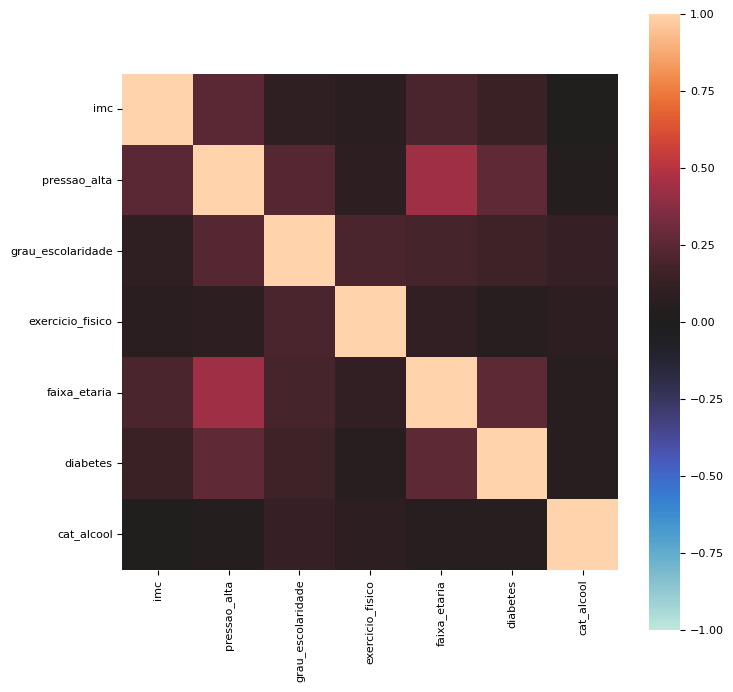

In [60]:
correlation = associations(df_model, filename= 'correlation.png', 
                                    figsize=(8,8),
                                    annot=False)

In [ ]:
# df_model = df_model[~df_model['itemid']==]
# lab_events_withoutexam['cat_alcool'] = 0

# neutro_labevents_min = neutro_labevents_min[neutro_labevents_min['itemid'].isin(neutro_itemid_loinc_min['itemid'])]
# neutro_labevents_min['cat_alcool'] = 1

# lab_events_withexam = neutro_labevents_min.copy()
# neutro_labevents_min = pd.concat([lab_events_withexam, lab_events_withoutexam], ignore_index=True)

In [61]:
def one_hot_encode(df,cols):
  # checar se são todos uniques
  # for col in cols:
    # display(df[col].unique())
  df = pd.get_dummies(data=df, columns=cols)
  display(df)
  return df

# df_model = one_hot_encode(df_model,cols=['pressao_alta','exercicio_fisico','grau_escolaridade','bebida_alcoolica','faixa_etaria'])
#convertendo a categoria de alcool em categorica
# df_model = one_hot_encode(df_model,cols=['pressao_alta','exercicio_fisico','grau_escolaridade','cat_alcool','faixa_etaria'])
# deixando a categoria como contínua
df_model = one_hot_encode(df_model,cols=['pressao_alta','exercicio_fisico','grau_escolaridade','faixa_etaria'])
df_model

,imc,diabetes,cat_alcool,pressao_alta_não,pressao_alta_sim,exercicio_fisico_não,exercicio_fisico_sim,grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau,grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau,grau_escolaridade_3º grau ou curso superior,grau_escolaridade_admissão,grau_escolaridade_curso ginasial ou ginásio,grau_escolaridade_curso primário,grau_escolaridade_nunca estudou,"grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)",faixa_etaria_18 a 24,faixa_etaria_25 a 34,faixa_etaria_35 a 44,faixa_etaria_45 a 54,faixa_etaria_55 a 64,faixa_etaria_65+
0,25.7,não,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,32.0,não,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,17.6,não,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,26.5,não,2,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,26.0,sim,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235425,18.8,não,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
235426,26.3,não,2,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
235427,27.8,não,2,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
235428,22.1,não,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


,imc,diabetes,cat_alcool,pressao_alta_não,pressao_alta_sim,exercicio_fisico_não,exercicio_fisico_sim,grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau,grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau,grau_escolaridade_3º grau ou curso superior,grau_escolaridade_admissão,grau_escolaridade_curso ginasial ou ginásio,grau_escolaridade_curso primário,grau_escolaridade_nunca estudou,"grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)",faixa_etaria_18 a 24,faixa_etaria_25 a 34,faixa_etaria_35 a 44,faixa_etaria_45 a 54,faixa_etaria_55 a 64,faixa_etaria_65+
0,25.7,não,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,32.0,não,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,17.6,não,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,26.5,não,2,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,26.0,sim,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235425,18.8,não,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
235426,26.3,não,2,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
235427,27.8,não,2,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
235428,22.1,não,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [62]:
df_model['diabetes'] = df_model['diabetes'].map({'não':0,
                                                             'sim':1
                                                             })

In [63]:
df_model

,imc,diabetes,cat_alcool,pressao_alta_não,pressao_alta_sim,exercicio_fisico_não,exercicio_fisico_sim,grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau,grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau,grau_escolaridade_3º grau ou curso superior,grau_escolaridade_admissão,grau_escolaridade_curso ginasial ou ginásio,grau_escolaridade_curso primário,grau_escolaridade_nunca estudou,"grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)",faixa_etaria_18 a 24,faixa_etaria_25 a 34,faixa_etaria_35 a 44,faixa_etaria_45 a 54,faixa_etaria_55 a 64,faixa_etaria_65+
0,25.7,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,32.0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,17.6,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,26.5,0,2,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,26.0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235425,18.8,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
235426,26.3,0,2,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
235427,27.8,0,2,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
235428,22.1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


# Correlação

In [64]:
def correlogram(df, limiar):
    df_selec_corr = df.corr(method='pearson')
    limiar = limiar
    nr = df_selec_corr.shape[0]
    C = df_selec_corr.to_numpy()
    M = np.zeros((nr, nr))
    for i in range(nr):
        for j in range(nr):
            if C[i, j] >= limiar:
                if i != j:
                    M[i, j] = 1

    np.set_printoptions(threshold=np.inf)

    n = M.shape[0]
    plt.figure(figsize=(8, 8))
    plt.rcParams.update({'font.size': 8})
    plt.axis('off')
    axis = np.linspace(0, 2 * np.pi, n, endpoint=False)
    x, y = np.cos(axis), np.sin(axis)
    offset = 0.1  # Adjust the offset value as needed

    for i in range(n):
        for j in range(i + 1, n):
            if M[i, j] == 1:
                correlation = C[i, j]
                line_color = 'b' if correlation >= 0 else 'r'  # Use blue for positive correlation, red for negative correlation
                line_width = abs(correlation) * 2  # Scale line width based on correlation magnitude
                plt.plot((x[i], x[j]), (y[i], y[j]), color=line_color, linewidth=line_width)

    plt.scatter(x, y)

    for i, txt in enumerate(df_selec_corr.columns.values):
        if y[i] >= 0:
            if x[i] < 0:
                plt.annotate(txt, (x[i] - offset, y[i] + offset))  # Add negative offset for left top annotations
            else:
                plt.annotate(txt, (x[i] + offset, y[i] + offset))  # Add positive offset for right top annotations
        else:
            if x[i] < 0:
                plt.annotate(txt, (x[i] - offset, y[i] - offset))  # Add negative offset for left bottom annotations
            else:
                plt.annotate(txt, (x[i] + offset, y[i] - offset))  # Add positive offset for right bottom annotations

    plt.show()

In [65]:
def correlogram(df, limiar,offset = 0.08):
    df_selec_corr = df.corr(method='pearson')
    limiar = limiar
    nr = df_selec_corr.shape[0]
    C = df_selec_corr.to_numpy()
    M = np.zeros((nr, nr))
    
    for i in range(nr):
        for j in range(nr):
            if abs(C[i, j]) >= abs(limiar) and i != j:
                M[i, j] = 1

    np.set_printoptions(threshold=np.inf)

    n = M.shape[0]
    plt.figure(figsize=(8, 8))
    plt.rcParams.update({'font.size': 8})
    plt.axis('off')
    axis = np.linspace(0, 2 * np.pi, n, endpoint=False)
    x, y = np.cos(axis), np.sin(axis)
    offset = offset  # Adjust the offset value as needed

    for i in range(n):
        for j in range(i + 1, n):
            if M[i, j] == 1:
                correlation = C[i, j]
                line_color = 'b' if correlation >= 0 else 'r'  # Use blue for positive correlation, red for negative correlation
                line_width = abs(correlation) * 2  # Scale line width based on correlation magnitude
                plt.plot((x[i], x[j]), (y[i], y[j]), color=line_color, linewidth=line_width)

    plt.scatter(x, y)

    for i, txt in enumerate(df_selec_corr.columns.values):
        if len(txt) > 10:
            txt = txt[:10] + '...' + txt[-10:]  # Truncate the string if it's longer than 10 characters
        if txt == 'diabetes':
            plt.annotate(txt, (x[i] , y[i]), weight='bold', ha='center', va='center')
        elif y[i] >= 0:
            if x[i] < 0:
                plt.annotate(txt, (x[i] - offset, y[i] + offset))  # Add negative offset for left top annotations
                plt.arrow(x[i], y[i] , -0.4*offset, 0.4*offset, color='black', width=0.005, head_width=0.03, head_length=0.03)
            else:
                plt.annotate(txt, (x[i] + offset, y[i] + offset))  # Add positive offset for right top annotations
                plt.arrow(x[i] , y[i] , 0.4*offset, 0.4*offset, color='black', width=0.005, head_width=0.03, head_length=0.03)
        else:
            if x[i] < 0:
                plt.annotate(txt, (x[i] - offset, y[i] - offset))  # Add negative offset for left bottom annotations
                plt.arrow(x[i] , y[i] , -0.4*offset, -0.4*offset, color='black', width=0.005, head_width=0.03, head_length=0.03)
            else:
                plt.annotate(txt, (x[i] + offset, y[i] - offset))  # Add positive offset for right bottom annotations
                plt.arrow(x[i], y[i], 0.4*offset, -0.4*offset, color='black', width=0.005, head_width=0.03, head_length=0.03)
    plt.show()

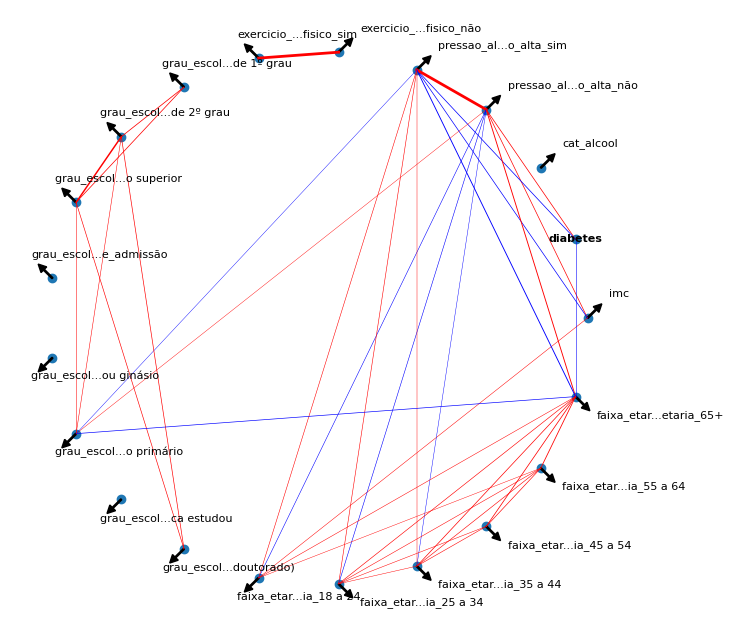

In [66]:
correlogram(df_model,limiar=0.15)

# Modelagem

## Bibliotecas e funções

In [67]:
# model training
from sklearn import linear_model
# Check https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier
from sklearn.linear_model import SGDClassifier # Log losss for logistic regressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import OneClassSVM

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.metrics import precision_recall_fscore_support
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import matthews_corrcoef, make_scorer
! pip -q install optuna
import optuna

from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn import tree
# tree.plot_tree(model.estimators_[0])

In [94]:
def train_model(X_train, X_val, y_train, y_val, grid_search=False,trials=10,view_trees=False,model='baseline'):

    scaler = MinMaxScaler()
    normalized_train_X = scaler.fit_transform(X_train)

    X_train = normalized_train_X
    # normalize X validation
    normalized_X_val = scaler.fit_transform(X_val)
    X_val = normalized_X_val
    if grid_search:
      print("user chose to do gridsearch")
      def create_model(trial):

        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'max_depth': trial.suggest_int('max_depth', 4, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
        }

        model = RandomForestClassifier(random_state=SEED, **params)

        return model
      
      def objective(trial:optuna.trial.Trial):
          params = {
              'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
              'max_depth': trial.suggest_int('max_depth', 4, 50),
              'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
              'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
          }

          model = create_model(trial)
          model.fit(normalized_train_X, y_train)
          y_pred = model.predict(X_val)
          score = balanced_accuracy_score(y_val, y_pred)
          return score


      study_rf = optuna.create_study(direction='maximize')
      study_rf.optimize(objective, n_trials=trials)

      fig = optuna.visualization.plot_optimization_history(study_rf)
      fig.show()

      # criação do modelo que performou melhor
      print("creating best model predictions")
      model = create_model(study_rf.best_trial)
      display(model)
      display(model.get_params())

      model.fit(normalized_train_X ,y_train)
      y_pred = model.predict(X_val)

    else:
      print("running models with no gridsearch")
      if model =='baseline':
        # baseline
        model = RandomForestClassifier(random_state=SEED,n_estimators= 500, max_depth=30, min_samples_leaf=5, n_jobs=-1)
      elif model =='tuned':
        # tunado sem SMOTE
        model = RandomForestClassifier(max_depth=46, n_estimators=842, random_state=SEED)
      elif model =='tunedsmote':
        # tunado com SMOTE
        model = RandomForestClassifier(max_depth=11, min_samples_leaf=34, min_samples_split=72,
                        n_estimators=160, random_state=SEED)
      elif model =='tunedadasys':
        params = {'bootstrap': True,
                  'ccp_alpha': 0.0,
                  'criterion': 'gini',
                  'max_depth': 8,
                  'max_features': 'sqrt',
                  'min_impurity_decrease': 0.0,
                  'min_samples_leaf': 1,
                  'min_samples_split': 146,
                  'min_weight_fraction_leaf': 0.0,
                  'n_estimators': 272,
                  'oob_score': False,
                  'verbose': 0,
                  'warm_start': False}       
        model = RandomForestClassifier(random_state=SEED, **params)
      else:
        print("specify model params")

      model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    return model, X_val,y_pred, y_val

In [69]:
def print_classification_report(y_val, y_val_pred):
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_balanced_accuracy = balanced_accuracy_score(y_val, y_val_pred)
    print("Acurácia na validação: {:.2f}%".format(val_accuracy * 100))
    print("Acurácia balanceada na validação: {:.2f}%".format(val_balanced_accuracy * 100))

    # Gerando o relatório com diversas métricas
    report = classification_report(y_val, y_val_pred)

    # Exibindo o relatório
    print(report)
    
    # Plotando a matriz de confusão
    matriz_confusão = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(matriz_confusão, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()
    plt.close()
    

## Divisão em X e y

In [70]:
X =  df_model.drop('diabetes', axis=1)

y = df_model['diabetes']

In [71]:
display(X)
display(y)

,imc,cat_alcool,pressao_alta_não,pressao_alta_sim,exercicio_fisico_não,exercicio_fisico_sim,grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau,grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau,grau_escolaridade_3º grau ou curso superior,grau_escolaridade_admissão,grau_escolaridade_curso ginasial ou ginásio,grau_escolaridade_curso primário,grau_escolaridade_nunca estudou,"grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)",faixa_etaria_18 a 24,faixa_etaria_25 a 34,faixa_etaria_35 a 44,faixa_etaria_45 a 54,faixa_etaria_55 a 64,faixa_etaria_65+
0,25.7,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,32.0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,17.6,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,26.5,2,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,26.0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235425,18.8,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
235426,26.3,2,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
235427,27.8,2,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
235428,22.1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


0         0
1         0
2         0
3         0
4         1
         ..
235425    0
235426    0
235427    0
235428    0
235429    0
Name: diabetes, Length: 235430, dtype: int64

## Divisão do dataset em treino teste e validação

In [72]:
# Set a seed for reproducibility purpose
SEED=21

train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# train é 70% do dataset - 30% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=SEED, shuffle=True)

# test é 15% do dataset inicial - 0.15/0.3 = 50% dos 30% de antes
# validation é 15% do dataset inicial
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=SEED, shuffle=True) 


## Parar antes de rodar modelo

In [ ]:
breakpointbeforerunningmodel

## Treinamento e avaliação

In [73]:
model, X_val,y_pred, y_val = train_model(X_train, X_val, y_train, y_val,grid_search =False,model='tuned')

running models with no gridsearch


Acurácia na validação: 88.25%
Acurácia balanceada na validação: 52.76%
              precision    recall  f1-score   support

           0       0.90      0.97      0.94     31765
           1       0.25      0.08      0.12      3550

    accuracy                           0.88     35315
   macro avg       0.58      0.53      0.53     35315
weighted avg       0.84      0.88      0.86     35315



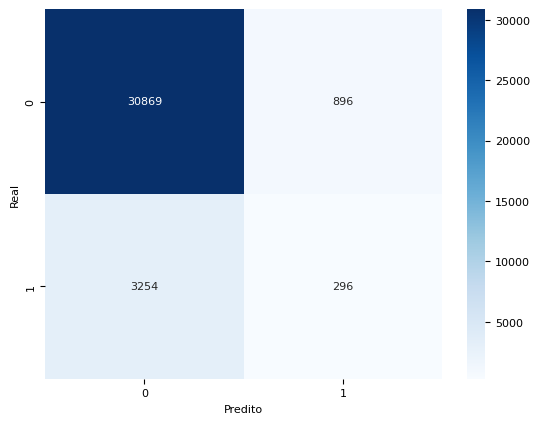

In [74]:
print_classification_report(y_val, y_pred)

## Referência métricas

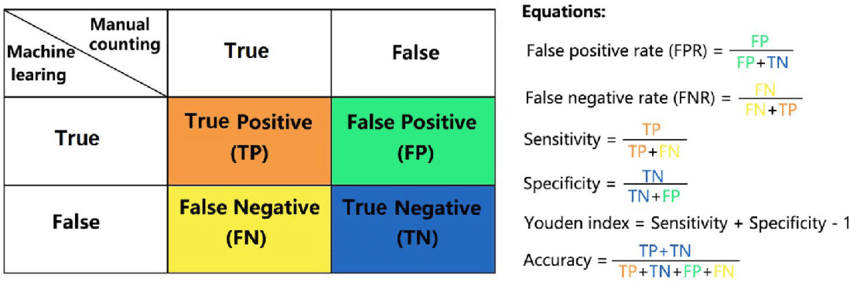

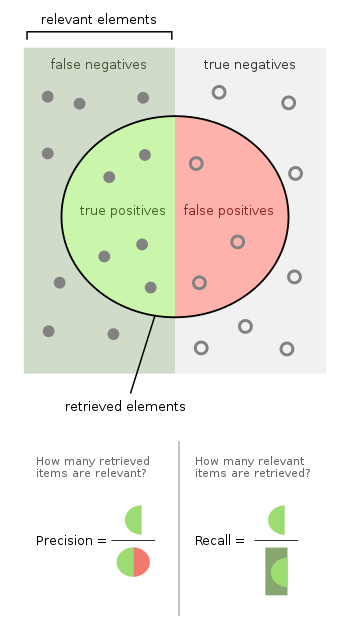

quais dados ele errou?

In [75]:
df_wrong = X_val[y_val != y_pred]

In [76]:
X_val[(y_val == 0) & (y_pred== 1)]

array([[0.21338912, 0.        , 0.        , 1.        , 1.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.10878661, 0.        , 0.        , 1.        , 1.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.42677824, 0.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.37656904, 0.57142857, 0.        , 1.        , 1.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

In [77]:
X_val[(y_val == 1) & (y_pred== 0)]

array([[0.25523013, 0.        , 0.        , 1.        , 1.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.70711297, 0.71428571, 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.31380753, 0.        , 0.        , 1.        , 1.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.14644351, 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0

In [78]:
X_val[(y_val == 0) & (y_pred[0]== 1)]

array([], shape=(0, 20), dtype=float64)

Predizeu que pessoas não eram diabéticas, quando eram. Faremos o balanceamento dos dados utilizando o SMOTE.

# Balanceamento dos dados

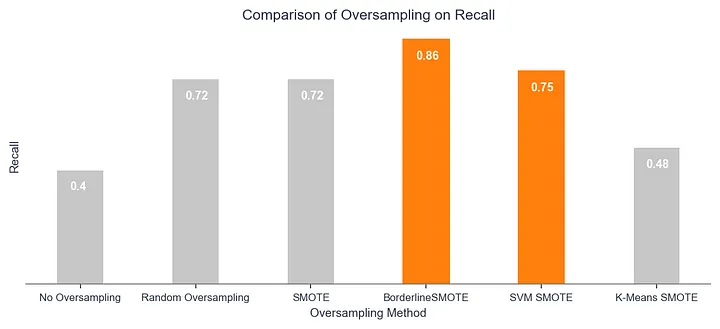 

Fonte: https://medium.com/analytics-vidhya/handling-imbalanced-data-by-oversampling-with-smote-and-its-variants-23a4bf188eaf

## SMOTE

O SMOTE é uma técnica de aumentação de dados deve ser aplicada depois de dividir os dados em conjuntos de treinamento e teste. É importante evitar qualquer vazamento de informações do conjunto de teste para o conjunto de treinamento durante o processo de reamostragem

como o smote funciona? https://medium.com/coinmonks/smote-and-adasyn-handling-imbalanced-data-set-34f5223e167

Goal: Increase the minority class so that the data set becomes balanced by creating synthetic observations based upon the existing minority observations.

SMOTE:

What smote does is simple. First it finds the n-nearest neighbors in the minority class for each of the samples in the class . Then it draws a line between the the neighbors an generates random points on the lines.

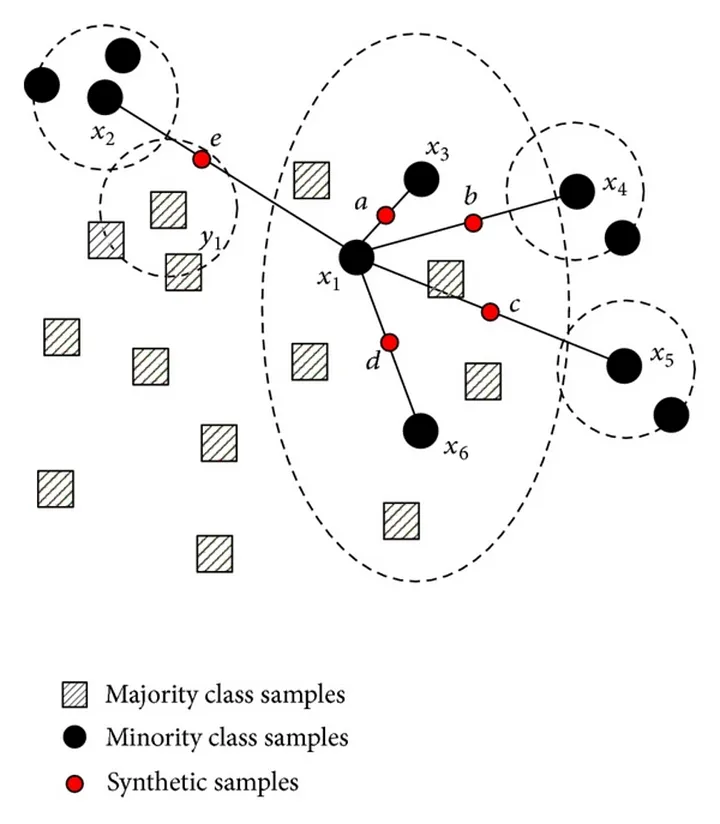

Select a sample, let’s call it O (for Origin), from the minority class randomly

Find the K-Nearest Neighbours of O that belong to the same class

Connect O to each of these neighbours using a straight line

Select a scaling factor ‘z’ in the range [0,1] randomly

For each new connection, place a new point on the line (z*100)% away from O. These will be our synthetic samples.

Repeat this process until you get the desired number of synthetic samples

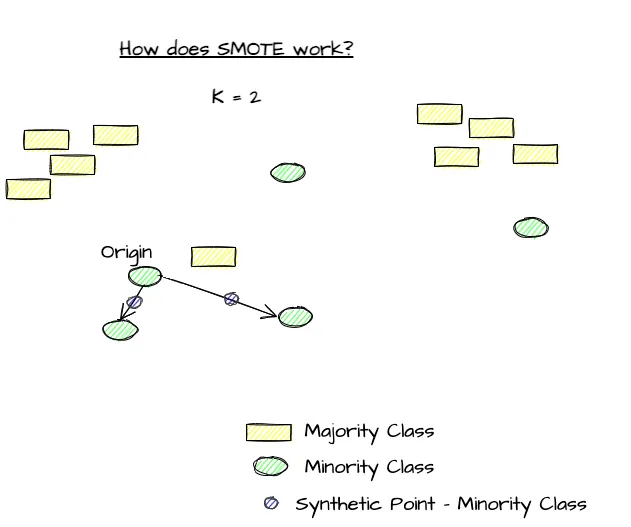

In [79]:
X =  df_model.drop('diabetes', axis=1)
y = df_model['diabetes']

In [80]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# train é 75% do dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=SEED, shuffle=True)

# test é 15% do dataset inicial
# validation é 15% do dataset inicial
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=SEED, shuffle=True) 

In [81]:
smote = SMOTE(random_state=SEED)
# Upsample the minority class using SMOTE
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Distribuição de diabéticos antes do SMOTE:")
print(y_train.value_counts())

print("Distribuição de diabéticos depois do SMOTE:")
print(y_resampled.value_counts())

Distribuição de diabéticos antes do SMOTE:
0    148804
1     15996
Name: diabetes, dtype: int64
Distribuição de diabéticos depois do SMOTE:
1    148804
0    148804
Name: diabetes, dtype: int64


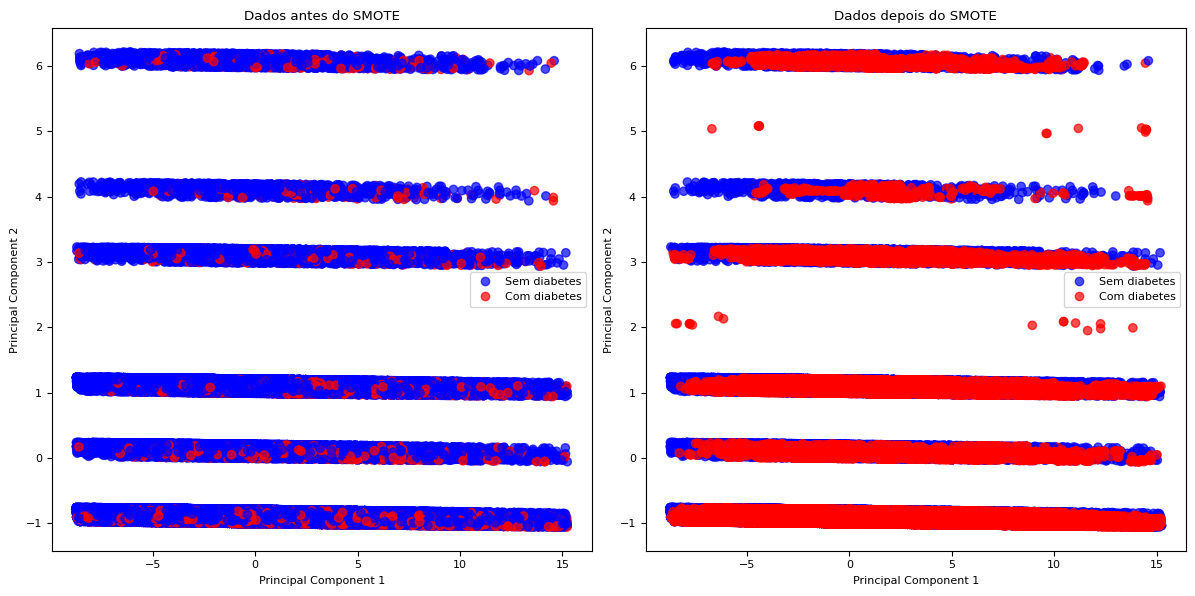

In [82]:
# Perform PCA for dimensionality reduction and visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_resampled_pca = pca.transform(X_resampled)

# Plot the data before and after SMOTE
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.title('Dados antes do SMOTE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=[plt.Line2D([], [], color='blue', marker='o', linestyle='None', alpha=0.7, label='Sem diabetes'),
                    plt.Line2D([], [], color='red', marker='o', linestyle='None', alpha=0.7, label='Com diabetes')])

plt.subplot(1, 2, 2)
plt.scatter(X_resampled_pca[:, 0], X_resampled_pca[:, 1], c=y_resampled, cmap='bwr', alpha=0.7)
plt.title('Dados depois do SMOTE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=[plt.Line2D([], [], color='blue', marker='o', linestyle='None', alpha=0.7, label='Sem diabetes'),
                    plt.Line2D([], [], color='red', marker='o', linestyle='None', alpha=0.7, label='Com diabetes')])

plt.tight_layout()
plt.show()

In [83]:
# x agora é o resampled
X_train= X_resampled.copy()
y_train = y_resampled.copy()

In [84]:
model, X_val,y_pred, y_val = train_model(X_train, X_val, y_train, y_val,grid_search =False,model='tunedsmote')

running models with no gridsearch


Acurácia na validação: 69.89%
Acurácia balanceada na validação: 72.79%
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     31765
           1       0.22      0.76      0.34      3550

    accuracy                           0.70     35315
   macro avg       0.59      0.73      0.57     35315
weighted avg       0.89      0.70      0.76     35315



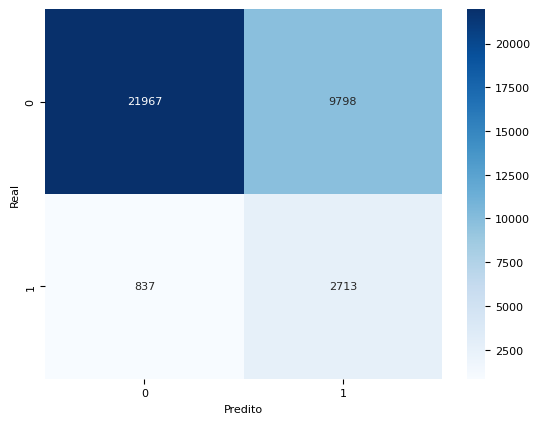

In [85]:
print_classification_report(y_val, y_pred)

Começa a acertar mais os que colocava como não diabéticos e compreender isso, no entanto agora começa a errar não diabéticos. Redução na acurácia mas aumento em métricas como o f1

https://stackoverflow.com/questions/40155128/plot-trees-for-a-random-forest-in-python-with-scikit-learn

In [ ]:
# plt.figure(figsize=(20,20))
# _ = tree.plot_tree(model.estimators_[0], feature_names=X.columns, filled=True)

## ADASYN

Its a improved version of Smote. What it does is same as SMOTE just with a minor improvement. After creating those sample it adds a random small values to the points thus making it more realistic. In other words instead of all the sample being linearly correlated to the parent they have a little more variance in them i.e they are bit scattered.

## Parar antes de testar opções de balanceamento

In [ ]:
breakpointbeforerunningothersamplingstrategies

In [86]:
X =  df_model.drop('diabetes', axis=1)
y = df_model['diabetes']

In [87]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# train é 75% do dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=SEED)

# test é 15% do dataset inicial
# validation é 15% do dataset inicial
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=SEED) 

In [88]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=SEED)
X_resampled, y_resampled = ada.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_resampled))

Resampled dataset shape Counter({1: 148950, 0: 148804})


In [89]:

print("Distribuição de diabéticos antes do SMOTE:")
print(y_train.value_counts())

print("Distribuição de diabéticos depois do SMOTE:")
print(y_resampled.value_counts())

Distribuição de diabéticos antes do SMOTE:
0    148804
1     15996
Name: diabetes, dtype: int64
Distribuição de diabéticos depois do SMOTE:
1    148950
0    148804
Name: diabetes, dtype: int64


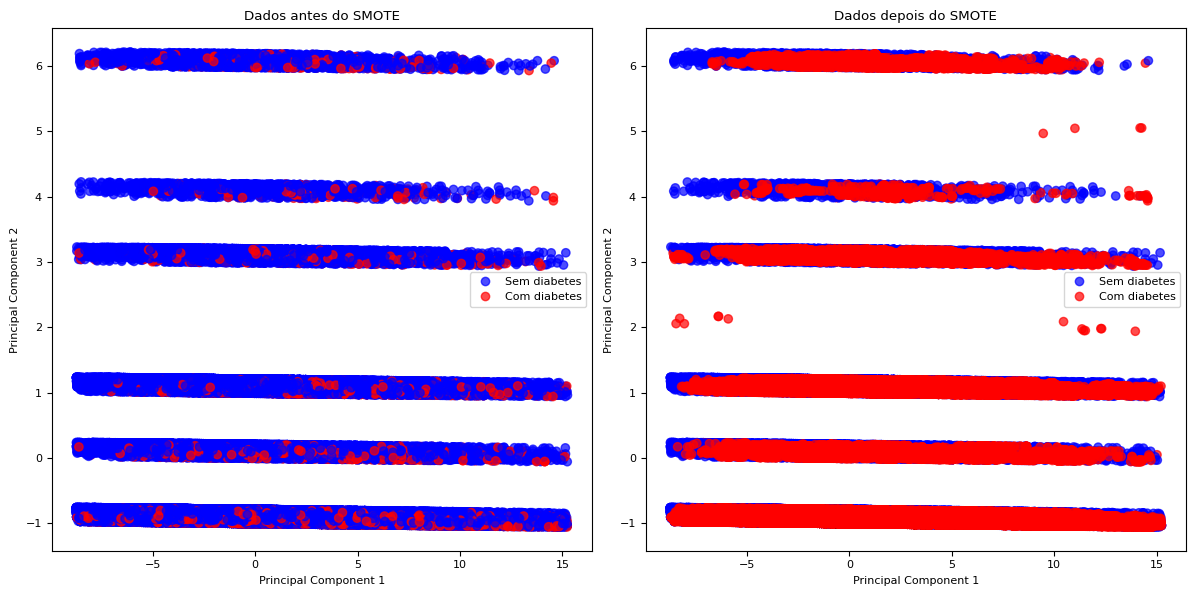

In [90]:
from sklearn.decomposition import PCA

# Perform PCA for dimensionality reduction and visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_resampled_pca = pca.transform(X_resampled)

# Plot the data before and after SMOTE
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.title('Dados antes do SMOTE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=[plt.Line2D([], [], color='blue', marker='o', linestyle='None', alpha=0.7, label='Sem diabetes'),
                    plt.Line2D([], [], color='red', marker='o', linestyle='None', alpha=0.7, label='Com diabetes')])

plt.subplot(1, 2, 2)
plt.scatter(X_resampled_pca[:, 0], X_resampled_pca[:, 1], c=y_resampled, cmap='bwr', alpha=0.7)
plt.title('Dados depois do SMOTE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=[plt.Line2D([], [], color='blue', marker='o', linestyle='None', alpha=0.7, label='Sem diabetes'),
                    plt.Line2D([], [], color='red', marker='o', linestyle='None', alpha=0.7, label='Com diabetes')])

plt.tight_layout()
plt.show()

In [91]:
# x agora é o resampled
X_train= X_resampled.copy()
y_train = y_resampled.copy()

sem gridsearch usando o tunado pra smote

In [95]:
model, X_val,y_pred, y_val = train_model(X_train, X_val, y_train, y_val,model='tunedadasys',grid_search =False)

running models with no gridsearch


Acurácia na validação: 68.39%
Acurácia balanceada na validação: 72.98%
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     31765
           1       0.21      0.79      0.33      3550

    accuracy                           0.68     35315
   macro avg       0.59      0.73      0.56     35315
weighted avg       0.89      0.68      0.75     35315



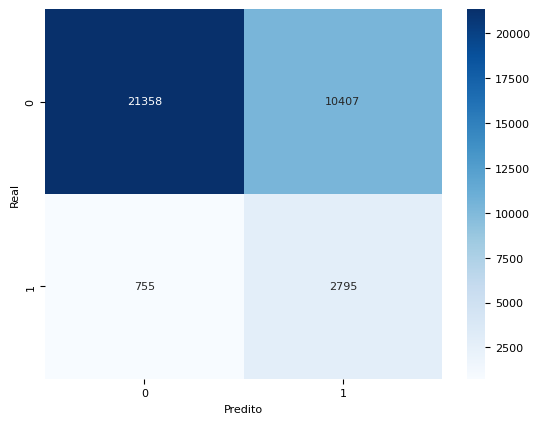

In [96]:
print_classification_report(y_val, y_pred)

com gridsearch

In [ ]:
# model, X_val,y_pred, y_val = train_model(X_train, X_val, y_train, y_val,grid_search =True,trials=10)

In [ ]:
# print_classification_report(y_val, y_pred)

o que queremos, ele errar diabéticos falando que tem é ruim? vai falar pra 11547 pessoas se cuidarem, ver esses dados que errou e tentar entender o motivo

## KMEANS SMOTE - não implementado

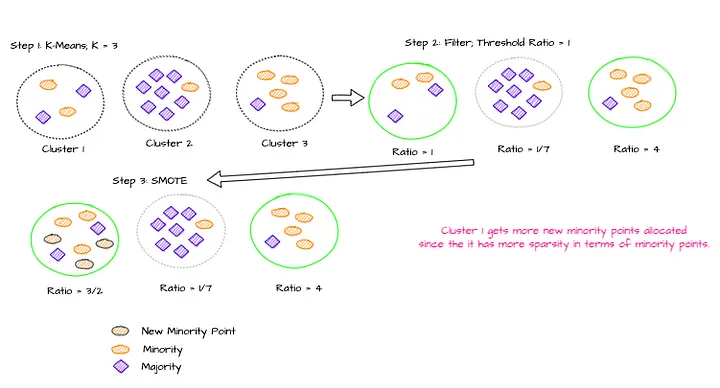

Do K-Means Clustering on the data. 

Select clusters that have a high proportion (>50% or user-defined) of minority class samples.

Apply conventional SMOTE to these selected clusters. Each cluster will be assigned new synthetic points. The number of these generated points will depend on the sparsity of the minority class in the cluster; the more the sparsity, the more new points.

## SVM SMOTE 

SVM SMOTE [4] focuses on increasing minority points along the decision boundary. The argument behind this is that instances around this boundary are critical for estimating the optimal decision boundary (which contrasts with the K-Means method we saw earlier but aligns with the Borderline variant).

So this is how this method works:

Train an SVM on your data. This will give you the support vectors (we focus on the minority class support vectors).
We then use these support vectors to generate new samples. For each of the support vectors, we find its K-Nearest Neighbours and create samples along the line joining the support vector and the nearest neighbours using either interpolation or extrapolation.
If less than half of the nearest neighbours belong to the majority class, then we do extrapolation. This helps expand the minority class area towards the majority area. If not, we do interpolation. The idea here is that since the majority of the neighbours belong to the majority class, we’d instead consolidate the current area of the minority class.

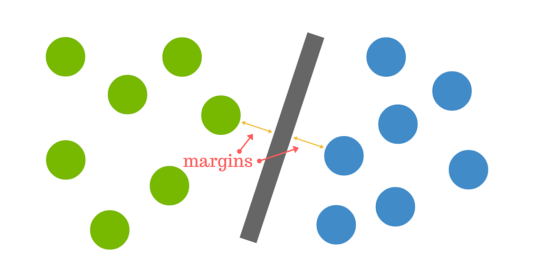

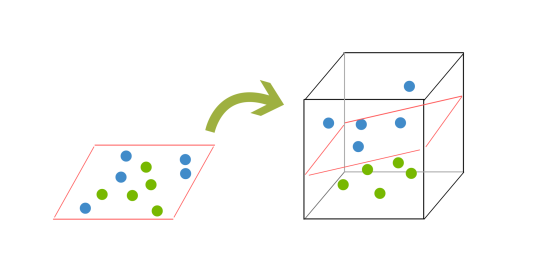

necessário converter o y 

In [ ]:
X =  df_model.drop('diabetes', axis=1)
y = df_model['diabetes'].astype(np.uint8)

In [ ]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# train é 75% do dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=SEED)

# test é 15% do dataset inicial
# validation é 15% do dataset inicial
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=SEED) 

In [ ]:
from imblearn.over_sampling import SVMSMOTE 
y_train = y_train.astype(np.uint8)
smote =SVMSMOTE(random_state = SEED)
# Upsample the minority class using SMOTE
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Distribuição de diabéticos antes do SMOTE:")
print(y_train.value_counts())

print("Distribuição de diabéticos depois do SMOTE:")
print(y_resampled.value_counts())

In [ ]:
# Perform PCA for dimensionality reduction and visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_resampled_pca = pca.transform(X_resampled)

# Plot the data before and after SMOTE
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.title('Dados antes do SMOTE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=[plt.Line2D([], [], color='blue', marker='o', linestyle='None', alpha=0.7, label='Sem diabetes'),
                    plt.Line2D([], [], color='red', marker='o', linestyle='None', alpha=0.7, label='Com diabetes')])

plt.subplot(1, 2, 2)
plt.scatter(X_resampled_pca[:, 0], X_resampled_pca[:, 1], c=y_resampled, cmap='bwr', alpha=0.7)
plt.title('Dados depois do SMOTE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=[plt.Line2D([], [], color='blue', marker='o', linestyle='None', alpha=0.7, label='Sem diabetes'),
                    plt.Line2D([], [], color='red', marker='o', linestyle='None', alpha=0.7, label='Com diabetes')])

plt.tight_layout()
plt.show()

In [ ]:
# x agora é o resampled
X_train= X_resampled.copy()
y_train = y_resampled.copy()

treinado com o modelo tunado pelo ADASYN, fazer grid search aqui também

In [ ]:
model, X_val,y_pred, y_val = train_model(X_train, X_val, y_train, y_val,grid_search =False,model='tunedadasys')

In [ ]:
print_classification_report(y_val, y_pred)

## Borderline SMOTE

In [97]:
X =  df_model.drop('diabetes', axis=1)
y = df_model['diabetes']

In [98]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# train é 75% do dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=SEED)

# test é 15% do dataset inicial
# validation é 15% do dataset inicial
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=SEED) 

In [99]:
from imblearn.over_sampling import BorderlineSMOTE

smote = BorderlineSMOTE(random_state = SEED, kind = 'borderline-2')
# Upsample the minority class using SMOTE
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Distribuição de diabéticos antes do SMOTE:")
print(y_train.value_counts())

print("Distribuição de diabéticos depois do SMOTE:")
print(y_resampled.value_counts())

Distribuição de diabéticos antes do SMOTE:
0    148804
1     15996
Name: diabetes, dtype: int64
Distribuição de diabéticos depois do SMOTE:
0    148804
1    148803
Name: diabetes, dtype: int64


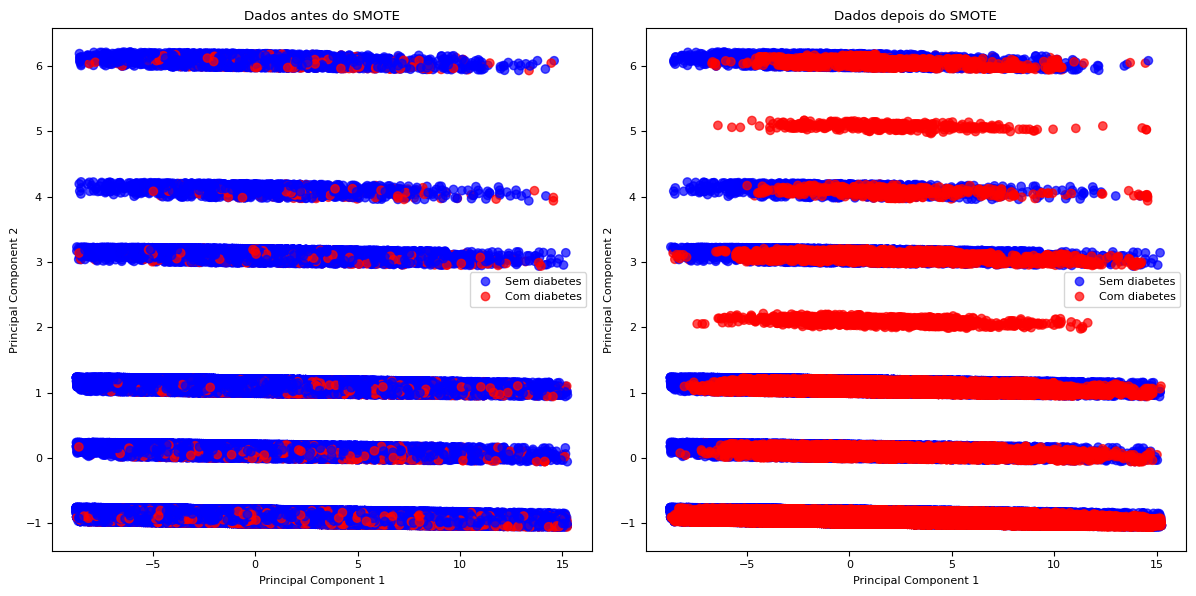

In [100]:
# Perform PCA for dimensionality reduction and visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_resampled_pca = pca.transform(X_resampled)

# Plot the data before and after SMOTE
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.title('Dados antes do SMOTE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=[plt.Line2D([], [], color='blue', marker='o', linestyle='None', alpha=0.7, label='Sem diabetes'),
                    plt.Line2D([], [], color='red', marker='o', linestyle='None', alpha=0.7, label='Com diabetes')])

plt.subplot(1, 2, 2)
plt.scatter(X_resampled_pca[:, 0], X_resampled_pca[:, 1], c=y_resampled, cmap='bwr', alpha=0.7)
plt.title('Dados depois do SMOTE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=[plt.Line2D([], [], color='blue', marker='o', linestyle='None', alpha=0.7, label='Sem diabetes'),
                    plt.Line2D([], [], color='red', marker='o', linestyle='None', alpha=0.7, label='Com diabetes')])

plt.tight_layout()
plt.show()

In [101]:
# x agora é o resampled
X_train= X_resampled.copy()
y_train = y_resampled.copy()

treinado com o modelo tunado pelo outro SMOTE, fazer grid search aqui também

In [102]:
model, X_val,y_pred, y_val = train_model(X_train, X_val, y_train, y_val,grid_search =False,model='tunedsmote')

running models with no gridsearch


Acurácia na validação: 77.08%
Acurácia balanceada na validação: 71.50%
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     31765
           1       0.25      0.65      0.36      3550

    accuracy                           0.77     35315
   macro avg       0.60      0.71      0.61     35315
weighted avg       0.88      0.77      0.81     35315



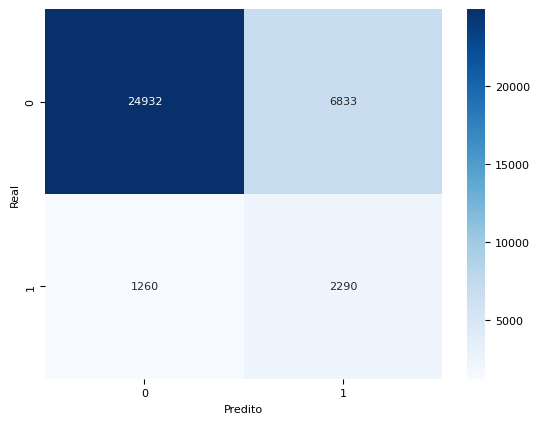

In [103]:
print_classification_report(y_val, y_pred)

## Downsample

In [104]:
X =  df_model.drop('diabetes', axis=1)
y = df_model['diabetes']

In [111]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# train é 75% do dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=SEED)

# test é 15% do dataset inicial
# validation é 15% do dataset inicial
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=SEED) 

In [113]:
df

,imc,cat_alcool,pressao_alta_não,pressao_alta_sim,exercicio_fisico_não,exercicio_fisico_sim,grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau,grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau,grau_escolaridade_3º grau ou curso superior,grau_escolaridade_admissão,grau_escolaridade_curso ginasial ou ginásio,grau_escolaridade_curso primário,grau_escolaridade_nunca estudou,"grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)",faixa_etaria_18 a 24,faixa_etaria_25 a 34,faixa_etaria_35 a 44,faixa_etaria_45 a 54,faixa_etaria_55 a 64,faixa_etaria_65+,diabetes
170681,25.5,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1
7810,30.1,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
162465,34.7,2,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
134484,24.1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
75741,27.9,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81968,37.5,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
140036,28.7,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
202552,23.1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
70863,31.0,2,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [114]:
# Concatenate X_train and y_train
df = pd.concat([X_train, y_train], axis=1)

# Count the occurrences of each class
class_counts = df['diabetes'].value_counts()

# Find the minority class label and its count
minority_class_label = class_counts.idxmin()
minority_class_count = class_counts.min()

# Downsampling the majority classes
df_downsampled = pd.concat([
    resample(df[df['diabetes'] == minority_class_label], 
             replace=False,  # Set to True if you want to allow repeated samples from the minority class
             n_samples=minority_class_count),
    *[resample(df[df['diabetes'] == label], replace=False, n_samples=minority_class_count) for label in class_counts.index if label != minority_class_label]
])

# Separate X_train and y_train after downsampling
X_train_downsampled = df_downsampled.iloc[:, :-1]
y_train_downsampled = df_downsampled.iloc[:, -1]



X_train_downsampled:
         imc  cat_alcool  pressao_alta_não  pressao_alta_sim  \
161174  27.0           0                 0                 1   
156756  35.0           0                 0                 1   
220971  23.6           2                 1                 0   
81902   24.2           0                 1                 0   
126451  32.4           0                 0                 1   
...      ...         ...               ...               ...   
126669  24.0           0                 0                 1   
150620  21.3           0                 1                 0   
163483  27.7           0                 1                 0   
215873  27.8           0                 1                 0   
8519    29.2           0                 1                 0   

        exercicio_fisico_não  exercicio_fisico_sim  \
161174                     1                     0   
156756                     1                     0   
220971                     1                    

In [115]:
# Print the downsampled datasets
print("X_train_downsampled:")
print(len(X_train_downsampled))
print("\ny_train_downsampled:")
print(len(y_train_downsampled))

X_train_downsampled:
31992

y_train_downsampled:
31992


In [116]:
y_train_downsampled

161174    1
156756    1
220971    1
81902     1
126451    1
         ..
126669    0
150620    0
163483    0
215873    0
8519      0
Name: diabetes, Length: 31992, dtype: int64

In [117]:
# x agora é o resampled
X_train= X_train_downsampled.copy()
y_train = y_train_downsampled.copy()

In [118]:
model, X_val,y_pred, y_val = train_model(X_train, X_val, y_train, y_val,grid_search =False,model='tunedsmote')

running models with no gridsearch


Acurácia na validação: 68.40%
Acurácia balanceada na validação: 72.93%
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     31765
           1       0.21      0.79      0.33      3550

    accuracy                           0.68     35315
   macro avg       0.59      0.73      0.56     35315
weighted avg       0.89      0.68      0.75     35315



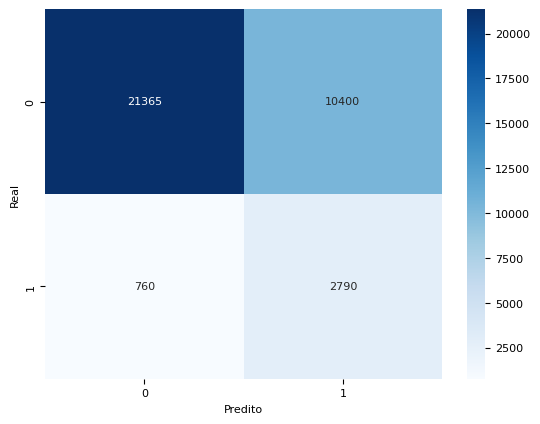

In [119]:
print_classification_report(y_val, y_pred)

# Tarefas



1.   Implementar gridsearch/optuna
2.   Tentar modelo mais pesado
3.   Alterar features? juntar exercício em algo em uma categoria só e comparar
4.   Critérios para a divisão de dados, pro smote e pro train test split, aplicar cross validation
5.   Colocar outras formas de avaliação do modelo, curva ROC e interpretar resultados
6.   Mostrar os modelos de forma explicável, arquitetura da árvore

Obs: o ideal é que todos dividam os dados da mesma forma e melhorem o baseline sem nunca observar o teste, para evitar vieses na construção do modelo

Minhas:

*   Plotar os casos FN E FP pra entender quais está errando
*   Colocar as opções de balanceamento dentro da de treinar modelo e deixar as funções menores e mais separadas
*   Entender como dividir os dados de forma equivalente, e validar se não é via balanceamento mesmo





opção: colocar a saída do PCA como entrada do modelo. paper: https://dergipark.org.tr/en/download/article-file/1777398

estudar: https://www.sciencedirect.com/topics/computer-science/false-negative

## teste de gpu

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

# referências antigas

In [ ]:
# import pdb
# pdb.set_trace()
# import sys
# !kill -9 -1
stopp

In [ ]:
# normalização

# Criando um objeto scaler
scaler = MinMaxScaler()

# Selecionando as colunas para normalização
cols_to_normalize = ['imc','peso']

# Aplicando a normalização min-max nas colunas selecionadas
df_ada[cols_to_normalize] = scaler.fit_transform(df_ada[cols_to_normalize])

In [ ]:
df_ada

In [ ]:
# Vamos primeiro separar as variáveis independentes (features) da variável dependente (target):
X = df_ada.drop('diabetes', axis=1)
y = df_ada['diabetes']

In [ ]:
def train_model(X, y, model_type='logistic_regression', grid_search=False):
    # Dividindo os dados em treino, validação e teste
    train_ratio = 0.75
    validation_ratio = 0.15
    test_ratio = 0.10

    # train é 75% do dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=42)

    # test é 10% do dataset inicial
    # validation é 10% do dataset inicial
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

    print(X_train, X_val, X_test)
    if model_type == 'logistic_regression':
        # Criando o modelo de Regressão Logística
        model = LogisticRegression(random_state=42)
        params = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10]}
    elif model_type == 'random_forest':
        # Criando o modelo de Random Forest
        model = RandomForestClassifier(random_state=42,max_depth=15)
        params = {'n_estimators': [100, 300, 500], 'max_depth': [5, 10,15, 20], 'min_samples_leaf': [1, 3, 5]}

    if grid_search:
        # Definindo os parâmetros para busca
        grid_search_cv = GridSearchCV(model, params, scoring='accuracy', cv=5, n_jobs=-1)

        # Treinando o modelo com a busca em grid
        grid_search_cv.fit(X_train, y_train)

        # Selecionando o melhor modelo encontrado na busca em grid
        model = grid_search_cv.best_estimator_

    # Treinando o modelo nos dados de treino
    model.fit(X_train, y_train)

    # Avaliando o modelo nos dados de validação
    y_pred = model.predict(X_val)

    return model, X_val, X_test, y_val,y_pred, y_test

In [ ]:
def print_classification_report(y_val, y_val_pred):
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_balanced_accuracy = balanced_accuracy_score(y_val, y_val_pred)
    print("Acurácia na validação: {:.2f}%".format(val_accuracy * 100))
    print("Acurácia balanceada na validação: {:.2f}%".format(val_balanced_accuracy * 100))

    # Gerando o relatório com diversas métricas
    report = classification_report(y_val, y_val_pred)

    # Exibindo o relatório
    print(report)
    
    # Plotando a matriz de confusão
    matriz_confusão = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(matriz_confusão, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()
    plt.close()
    

In [ ]:
model, X_val, X_test, y_val,y_pred, y_test = train_model(X, y)

In [ ]:
print_classification_report(y_val, y_pred)

In [ ]:
print(f'\n os pesos do modelo são:{model.coef_[0]} e o bias é {model.intercept_[0]}')

Balanceamento de classes

In [ ]:

# Separando as classes majoritária e minoritária
df_majority = df_ada[df_ada['diabetes'] == 0]
df_minority = df_ada[df_ada['diabetes'] == 1]

# Fazendo o downsample da classe majoritária
df_majority_downsampled = resample(df_majority, replace=False, n_samples=df_minority.shape[0], random_state=42)

# Concatenando as classes majoritária e minoritária
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Separando os dados de entrada (X) e a variável a ser prevista (y)
X = df_downsampled.drop('diabetes', axis=1)
y = df_downsampled['diabetes']

In [ ]:
# ax = sns.countplot(df_downsampled['diabetes'])
# for p in ax.patches:
#    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

In [ ]:
model, X_val, X_test, y_val,y_pred, y_test = train_model(X, y)
print("Parâmetros do modelo :")
print(model.get_params())

In [ ]:
print_classification_report(y_val, y_pred)

In [ ]:
model, X_val, X_test, y_val,y_pred, y_test = train_model(X, y,model_type = 'random_forest',grid_search=False)
print_classification_report(y_val, y_pred)
print(model.get_params())


In [ ]:
print(f'\n os pesos do modelo são:{model.feature_importances_} ')

In [ ]:
# random forest, com gridsearch demora uns 5 minutos

tic = time.perf_counter()
model, X_val, X_test, y_val,y_pred, y_test = train_model(X, y,model_type = 'random_forest',grid_search=True)
toc = time.perf_counter()
print_classification_report(y_val, y_pred)
print(model.get_params())

In [ ]:
time_train = toc-tic
print(f"Modelo treinado em {time_train/60:0.4f} minutos")

In [ ]:
df_ada

In [ ]:
print(f'\n os pesos do modelo são:{model.feature_importances_} ')